<center>
        <font size=20>Time Series Tips</font>
</center>

# Articles:
* Tian Jie - [Time Series Analysis with Statsmodels](https://towardsdatascience.com/time-series-analysis-with-statsmodels-12309890539a)

# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

# tsa = time series analysis
from statsmodels.tsa.deterministic import (DeterministicProcess, 
    CalendarFourier)
from statsmodels.graphics.tsaplots import plot_pacf

from IPython.display import Image

# XGBRegressor import causes warning
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)

# Datasets

## Book Sales

In [2]:
# import sample time series data
book_sales = pd.read_csv('data/book_sales.csv', index_col='Date', 
                         parse_dates=['Date'])
book_sales.head(3)

,Paperback,Hardcover
Date,,
2000-04-01,199,139
2000-04-02,172,128
2000-04-03,111,172


## US Retail Sales


In [3]:
retail_sales = pd.read_csv('data/us-retail-sales.csv', index_col='Month',
                           parse_dates=['Month'])
retail_sales.head(3)

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01-01,6938,3657,29589,26788,14996,8964
1992-02-01,7524,3490,28570,28203,16015,9023
1992-03-01,8475,3669,29682,31684,17984,10608


## Ecuador Store Sales

In [4]:
store_sales = pd.read_csv('data/store_sales_train.csv',
                    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                    parse_dates=['date'],
                    infer_datetime_format=True,
                    dtype={
                        'store_nbr': 'category',
                        'family': 'category',
                        'sales': 'float64',
                        'onpromotion': 'uint32'})
store_sales.head(2)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0


In [5]:
holidays_events = pd.read_csv('data/store_sales_holidays_events.csv',
                              parse_dates=['date'],
                              infer_datetime_format=True,
                              dtype={
                                  'type': 'category',
                                  'locale': 'category',
                                  'locale_name': 'category',
                                  'description': 'category',
                                  'transferred': 'bool'})

# set index
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head(3)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


## Federal Reserv

In [6]:
reserve = pd.read_csv('data/reserve.csv',
                      parse_dates={'Date': ['Year', 'Month', 'Day']},
                      index_col='Date')

reserve.head(3)

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
Date,,,,,,,
1954-07-01,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1954-08-01,NaN,NaN,NaN,1.22,NaN,6.0,NaN
1954-09-01,NaN,NaN,NaN,1.06,NaN,6.1,NaN


## Flu Trends

In [7]:
flu_trends = pd.read_csv('data/flu-trends.csv')
flu_trends.head(1)

,Week,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
0,2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,...,16,6,13,25,34,30,25,24,15,180


In [8]:
flu_trends = flu_trends.set_index(pd.PeriodIndex(flu_trends.Week, freq='W'))\
    .drop('Week', axis='columns')
flu_trends.head(1)

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180


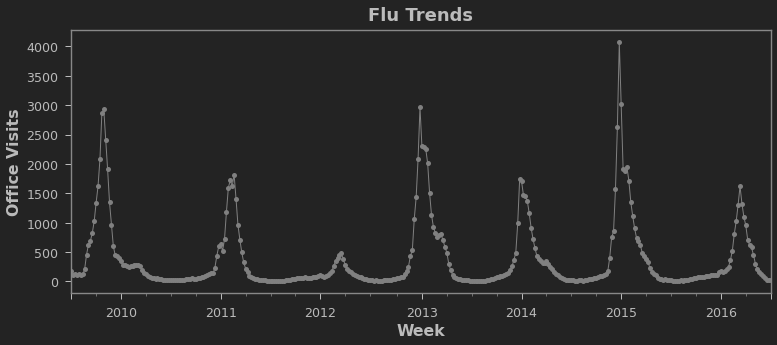

In [9]:
ax = flu_trends['FluVisits'].plot(title='Flu Trends', style='.-', 
            ylabel='Office Visits', color='grey', ms=10, lw=1)

# Time Dependent
Features we could derive directly from the time index. 

## Time-Step Features
Features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. 

In [10]:
df2 = book_sales.copy()
df2['Time'] = np.arange(len(df2.index))
df2.head(2)

,Paperback,Hardcover,Time
Date,,,
2000-04-01,199,139,0
2000-04-02,172,128,1


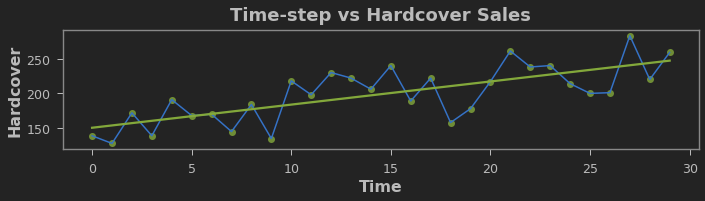

In [11]:
# plot Hardcover vs Time
fig, ax = plt.subplots(figsize=(10,3))

ax.plot('Time', 'Hardcover', data=df2)
ax = sns.regplot(x='Time', y='Hardcover', data=df2, ci=None)
ax.set_title('Time-step vs Hardcover Sales')

plt.show()

## Level
The **average value** in the time series data.

## Trend
The trend component of a time series represents a persistent, long-term **change** in the mean of the series. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

For a change to be a part of the trend, it should occur over a longer period than any seasonal changes.

To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series.

In [13]:
food_sales = retail_sales[['FoodAndBeverage']]
food_sales.index = food_sales.index.to_period('M')
food_sales.head(2)

,FoodAndBeverage
Month,
1992-01,29589
1992-02,28570


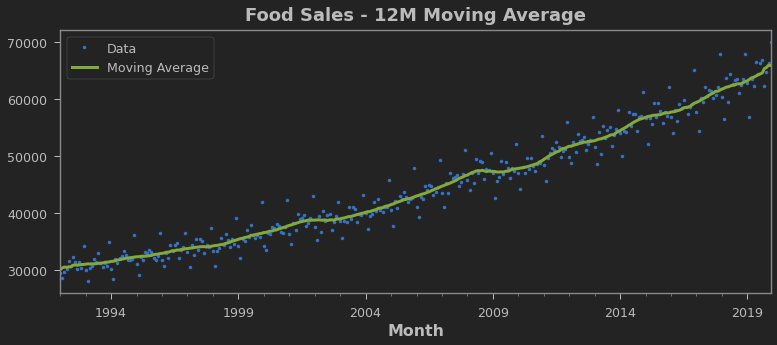

In [14]:
Time Series Tips
Articles:
Tian Jie - Time Series Analysis with Statsmodels
Imports
In [1]:
￼
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
​
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
​
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
​
# tsa = time series analysis
from statsmodels.tsa.deterministic import (DeterministicProcess, 
    CalendarFourier)
from statsmodels.graphics.tsaplots import plot_pacf
​
from IPython.display import Image
​
# XGBRegressor import causes warning
from xgboost import XGBRegressor
​
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)food_movavg = food_sales.rolling(
    window=12,       # 12-month window
    min_periods=6,   # half the window size
    center=True      # avg at the center of the window
).mean()             # could also be median, std, min,max ...

ax = food_sales.plot(style='.')
ax = food_movavg.plot(ax=ax, linewidth=3, 
                      title='Food Sales - 12M Moving Average')
_ = ax.legend(['Data', 'Moving Average'])

Upward bend might indicate a 2nd order trend.

### Linear & Quadratic Trend

In [15]:
y = food_sales['FoodAndBeverage']

# define 2 processes for linear and quadratic trends
dp1 = DeterministicProcess(
    index=y.index,  # training data dates
    constant=True,  # dummy feature (y_intercept)
    order=1,        # the time dummy (trend)
    drop=True)      # drop terms if necessary to avoid collinearity

dp2 = DeterministicProcess(
    index=food_sales.index,  
    constant=True,           
    order=2,                 
    drop=True)               

# generate training feature set
X1 = dp1.in_sample()
X2 = dp2.in_sample()
X1.head(2)

,const,trend
Month,,
1992-01,1.0,1.0
1992-02,1.0,2.0


Trend is just a <code>time-step</code> feature, ranging from 0 to len(n).

In [16]:
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model1 = LinearRegression(fit_intercept=False).fit(X1, y)
model2 = LinearRegression(fit_intercept=False).fit(X2, y)

y1_pred = pd.Series(model1.predict(X1), index=X1.index)
y2_pred = pd.Series(model2.predict(X2), index=X2.index)

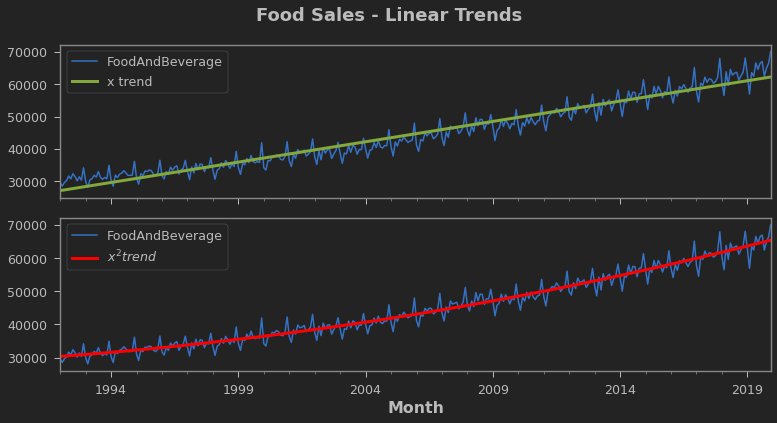

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11, 6))
fig.suptitle('Food Sales - Linear Trends', fontsize=18, weight='bold')

food_sales.plot(ax=axes[0])
y1_pred.plot(ax=axes[0], linewidth=3, label='x trend')

food_sales.plot(ax=axes[1])
y2_pred.plot(ax=axes[1], linewidth=3, color='red', label='$x^2  trend$')

_ = axes[0].legend()
_ = axes[1].legend()

##### Forecasting

In [18]:
X1_fore = dp1.out_of_sample(steps=60)
X2_fore = dp2.out_of_sample(steps=60)

y1_fore = pd.Series(model1.predict(X1_fore), index=X1_fore.index)
y2_fore = pd.Series(model2.predict(X2_fore), index=X2_fore.index)

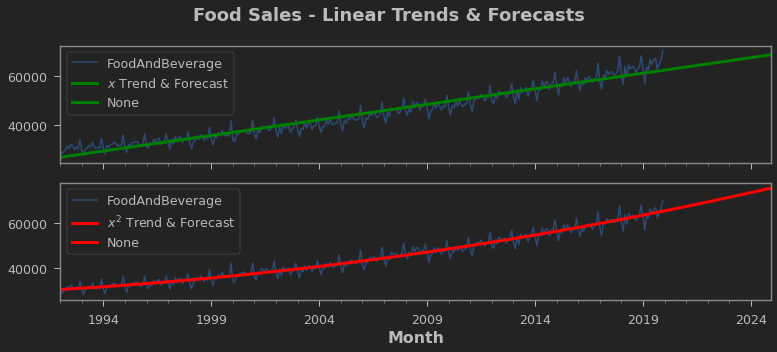

In [19]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11, 5))
fig.suptitle('Food Sales - Linear Trends & Forecasts', fontsize=18, weight='bold')

y.plot(ax=axes[0], alpha=0.5)
y1_pred.plot(ax=axes[0], linewidth=3, color='green', label='$x$ Trend & Forecast')
y1_fore.plot(ax=axes[0], linewidth=3, color='green')

y.plot(ax=axes[1], alpha=0.5)
y2_pred.plot(ax=axes[1], linewidth=3, color='red', label='$x^2$ Trend & Forecast')
y2_fore.plot(ax=axes[1], linewidth=3, color='red')

_ = axes[0].legend()
_ = axes[1].legend()

## Seasonality
We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

Two kinds of indicators that model seasonality:
* <code>Indicators</code> - best for a season with few observations, like a weekly season of daily observations.
* <code>Fourier features</code> - best for a season with many observations, like an annual season of daily observations.



### Seasonal Plots
Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe.

In [20]:
# define seasonal plot
def seasonal_plot(df, y, period, freq, ax=None):
    """Return seasonal plot axis."""
    
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette("husl", n_colors=df[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=df,
        ci=False,        # confidence interval
        ax=ax,
        palette=palette,
        legend=False,)
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    # annotate period on the plot
    for line, name in zip(ax.lines, df[period].unique()):
        y_ = line.get_ydata()[-1]              # grab last y value for period
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center")
    return ax

In [21]:
store_sales.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [22]:
store_sales2 = store_sales.copy()

store_sales2['date'] = store_sales2.date.dt.to_period('D')
store_sales2 = store_sales2.set_index(['store_nbr', 'family', 'date']).sort_index()

# average sales grouped by date
average_sales = (
    store_sales2
    .groupby('date').mean()
    .loc['2017']
    .sales
)
average_sales.head(2)

date
2017-01-01      6.780304
2017-01-02    786.928379
Freq: D, Name: sales, dtype: float64

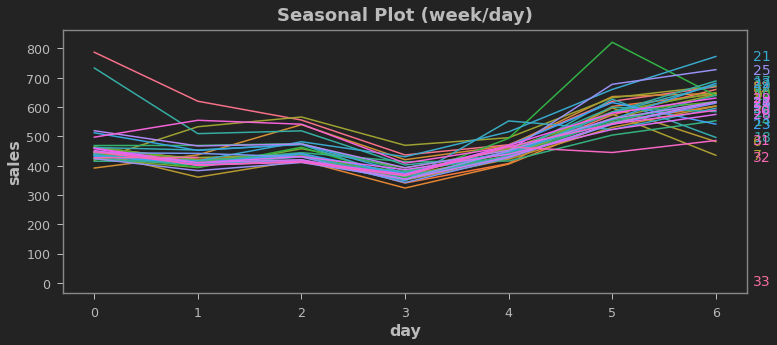

In [23]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

_ = seasonal_plot(df=X, y='sales', period='week', freq='day')

### Seasonal Indicators
Seasonal indicators are <code>binary features</code> that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply <code>one-hot encoding</code>.

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of 1 $(On)$.

In [24]:
X

,sales,week,day
date,,,
2017-01-01,6.780304,52,6
2017-01-02,786.928379,1,0
2017-01-03,619.740224,1,1
2017-01-04,555.608004,1,2
2017-01-05,436.375395,1,3
...,...,...,...
2017-08-11,463.733851,32,4
2017-08-12,444.798280,32,5
2017-08-13,485.768618,32,6


In [25]:
X2 = X.copy()
day_map = {0:'Mon', 1:'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fry', 5: 'Sat', 6: 'Sun'}

X2['day'] = X2.day.replace(day_map)
pd.get_dummies(X2, columns=['day'], prefix_sep='', prefix='', 
               drop_first=True).head(3)

,sales,week,Mon,Sat,Sun,Thu,Tue,Wed
date,,,,,,,,
2017-01-01,6.780304,52,0,0,1,0,0,0
2017-01-02,786.928379,1,1,0,0,0,0,0
2017-01-03,619.740224,1,0,0,0,0,1,0


By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; algorithm chose Friday in the frame above.)

### Fourier Features
Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

<code>Fourier features</code> are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

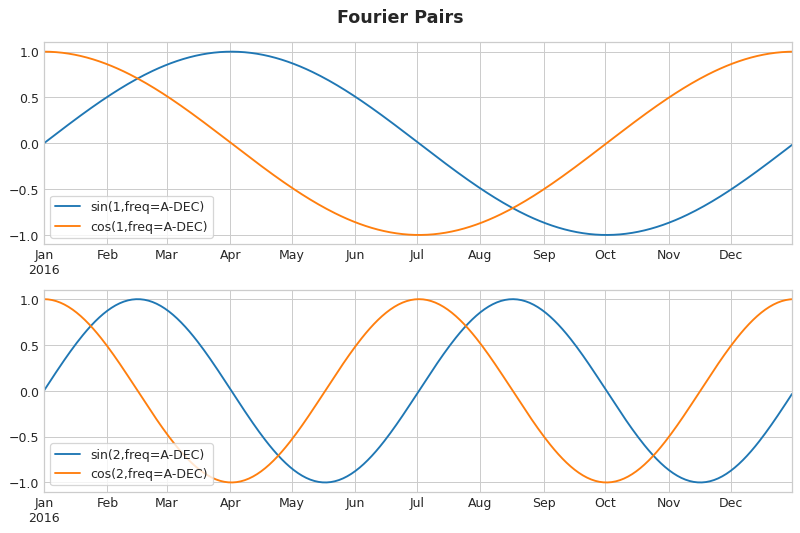

In [26]:
Image("img/fourier_features.png", height=100, width=500)

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the Wiki Trigonometry series.

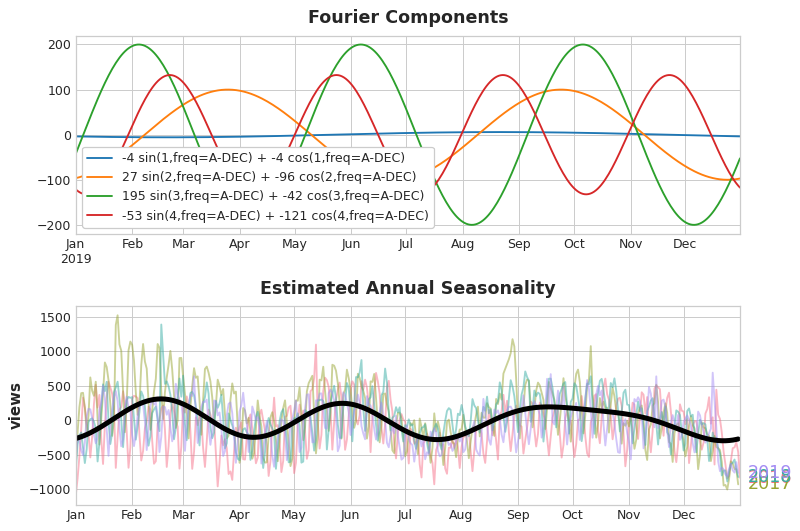

In [27]:
Image("img/fourier_sum.png", height=100, width=500)

* **Top**: Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. 
* **Bottom**: The sum of these curves approximates the seasonal pattern.

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

#### Periodogram
How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series.

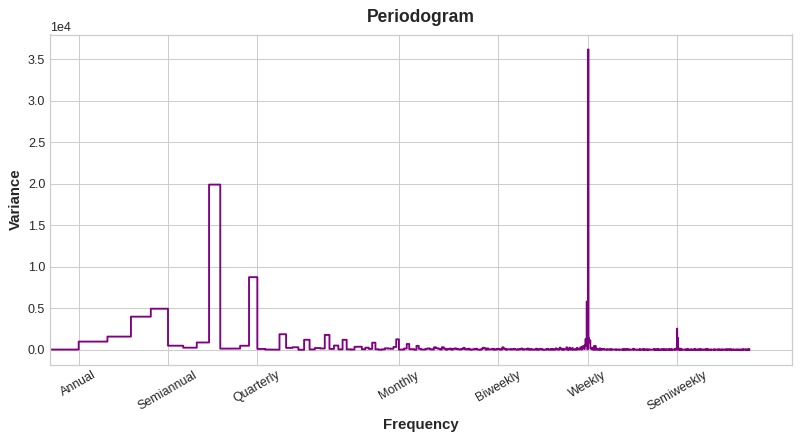

In [28]:
Image("img/periodogram.png", height=150, width=550)

From left to right, the periodogram drops off after Quarterly. Within that period we can distinguish **4** peaks: <code>Annual, Semiannual, 1/3, Quarterly</code>. That was why we chose four Fourier pairs (8 Fourier features) to model the annual season. The Weekly frequency we ignore since it's better modeled with dummy indicators.

In [29]:
# define function to draw periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    """Plot periodogram."""
    from scipy.signal import periodogram
    
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,                 # time series
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum')
    
    if ax is None:
        _, ax = plt.subplots()
        
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels([
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
    ],rotation=30)
    
    _ = ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    _ = ax.set_ylabel("Variance")
    _ = ax.set_title("Periodogram")
    return ax

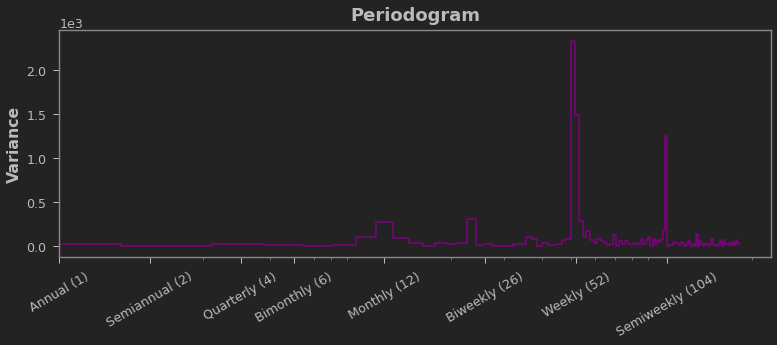

In [30]:
plot_periodogram(average_sales)
plt.show()

On this plot we can distinguish 2 peaks: <code>Monthly, Biweekly</code>, therefore 2 Fourier pairs and 4 Fourier features.

In [31]:
average_sales.head()

date
2017-01-01      6.780304
2017-01-02    786.928379
2017-01-03    619.740224
2017-01-04    555.608004
2017-01-05    436.375395
Freq: D, Name: sales, dtype: float64

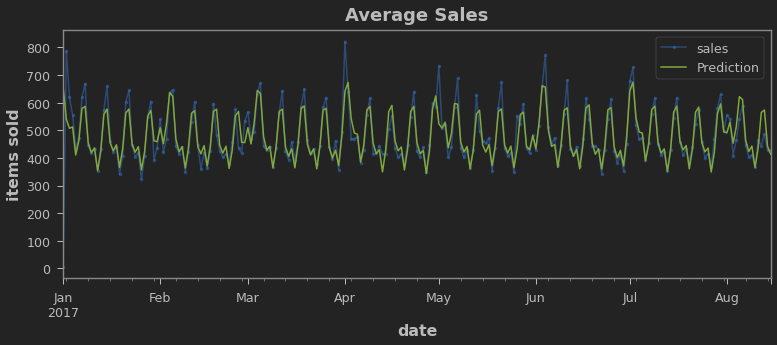

In [32]:
y = average_sales.copy()  # target values

# freq is chosen by largest seasonality
fourier = CalendarFourier(freq='M', order=4)

dp_seasonal = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True)

X_seasonal = dp_seasonal.in_sample()

# fit seasonal model & extract predicitons
model_seasonal = LinearRegression().fit(X_seasonal, y)
y_pred_seasonal = pd.Series(model_seasonal.predict(X_seasonal), 
                            index=X_seasonal.index)

ax = y.plot(alpha=0.5, title='Average Sales', ylabel='items sold', style='.-')
ax = y_pred_seasonal.plot(ax=ax, label='Prediction')
_ = ax.legend()

#### Deseasonalizing
Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

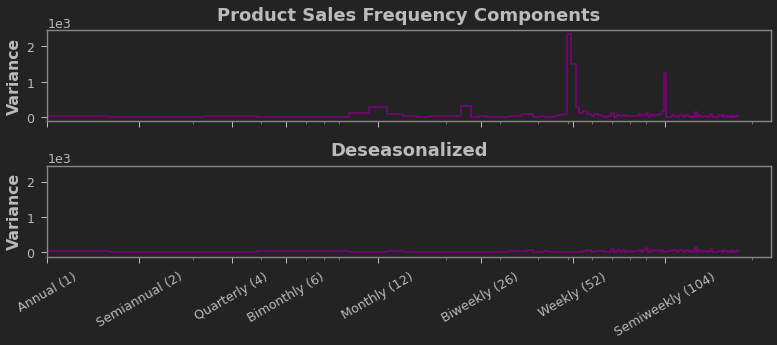

In [33]:
y_deseason = y - y_pred_seasonal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1 = plot_periodogram(y, ax=ax1)
_ = ax1.set_title('Product Sales Frequency Components')
ax2 = plot_periodogram(y_deseason, ax=ax2)
_ = ax2.set_title('Deseasonalized')

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

#### Holiday Features
Even though we have captured seasons in our data, we still might have captureable influences by certain **holidays**. Lets plot these special holidays on our deseasonalized data series.

In [34]:
# national and regional holidays
holidays_events.head(2)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [35]:
holidays_events['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

Let's capture only national and Regional holidays in span of 2017 - 2017-08-15

In [36]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


Lets plot these Holidays on our deseasonalized data.

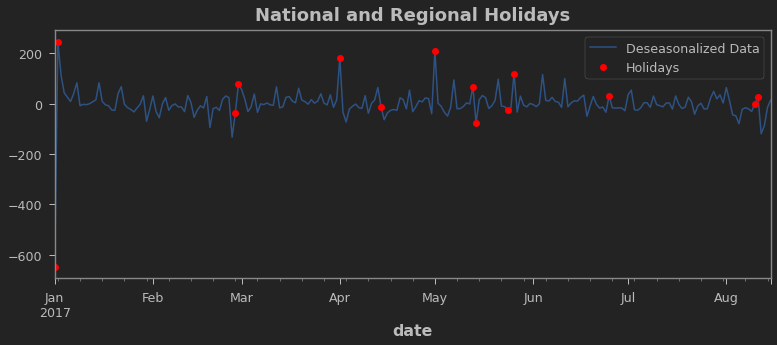

In [37]:
ax = y_deseason.plot(alpha=0.6, label='Deseasonalized Data')
plt.plot_date(x=holidays.index, y=y_deseason[holidays.index], color='red',
              label='Holidays')
_ = ax.set_title('National and Regional Holidays')
_ = ax.legend()

It appears these holidays could have some predictive power as some of them are at the peaks of deseasonalized data. Remember, seasons are discarded from this data, meaning, if there is variance in the data and these holidays coincide with the variance they have predictive power.

Since there are unperiodic finite number of holidays we just need to dummy encode them.

In [38]:
X.head(2)

,sales,week,day
date,,,
2017-01-01,6.780304,52,6
2017-01-02,786.928379,1,0


In [39]:
X_holidays = pd.get_dummies(holidays)

X3 = X.join(X_holidays, on='date').fillna(0.0)
X3.head(2)

,sales,week,day,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,
2017-01-01,6.780304,52,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,786.928379,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


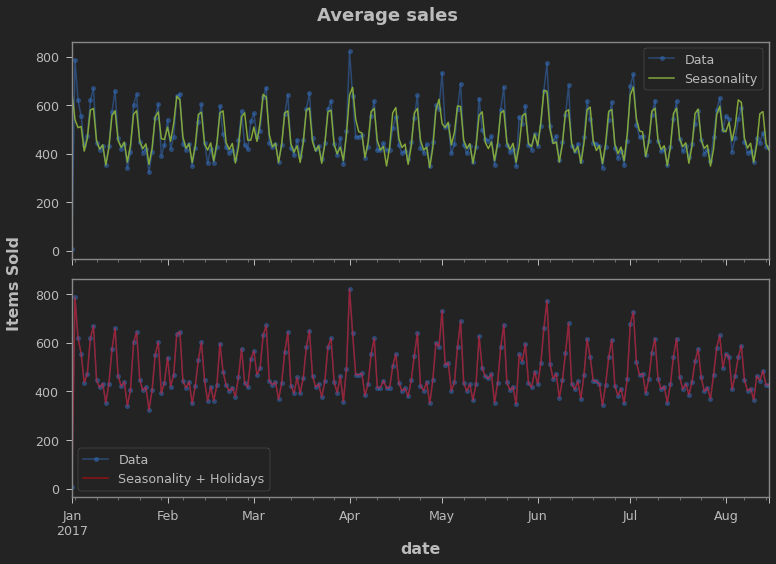

In [40]:
model_holy = LinearRegression().fit(X3, y)
y_holy_pred = pd.Series(model_holy.predict(X3), index=X3.index)


fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11, 8))
plt.suptitle('Average sales', fontsize=18, weight='bold')
fig.supylabel('Items Sold', weight='bold')

y.plot(alpha=0.5, label='Data', style='o-', ms=5, ax=axes[0])
y_pred_seasonal.plot(ax=axes[0], label='Seasonality')

y.plot(alpha=0.5, label='Data', style='o-', ms=5, ax=axes[1])
y_holy_pred.plot(ax=axes[1], label='Seasonality + Holidays', 
                 color='red', alpha=0.5)

_ = axes[0].legend()
_ = axes[1].legend()

Clearly adding Holidays into our model improves the prediction - on the training data.

# Serial Dependent
Using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear.

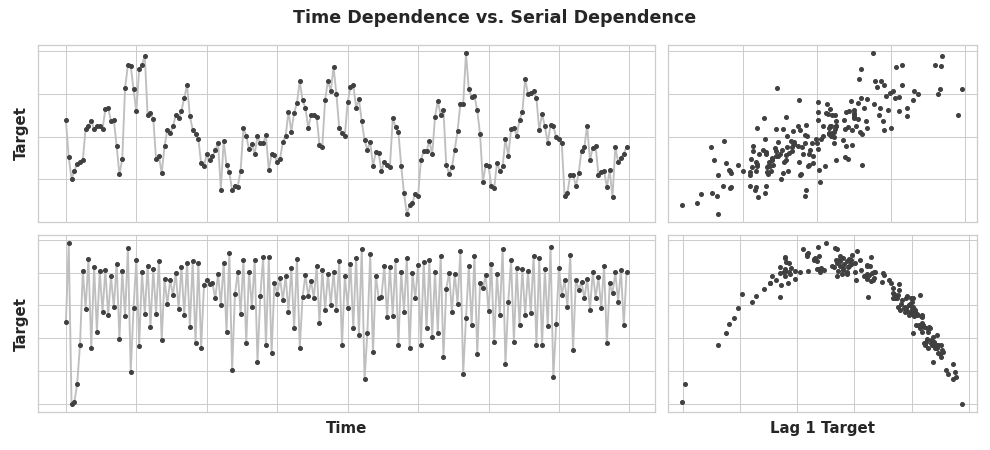

In [41]:
Image('img/serial_dependent.png')

These two series have serial dependence, but not time dependence. Points on the right have coordinates <code>(value at time t-1, value at time t)</code>

With trend and seasonality, we trained models to fit curves to plots like those on the left in the figure above -- the models were learning time dependence.The goal is to train models to fit curves to plots like those on the right -- we want them to learn serial dependence.

## Cycles
Serial dependence manifests in <code>cycles</code>. Cycles are:
* Patterns of growth & decay in time series associated with <code>value step</code> rather than time step itself.
* <code>Not time dependent</code> as seasonality is.
* Less about particular date of occurance and more about what happened in the recent past.
* Characteristic of systems that can <code>affect themselves</code>.
* Natural phenomena displays cyclic behaviour.
* The (relative) independence from time makes cyclic behaviour much more <code>irregular</code> than seasonality.

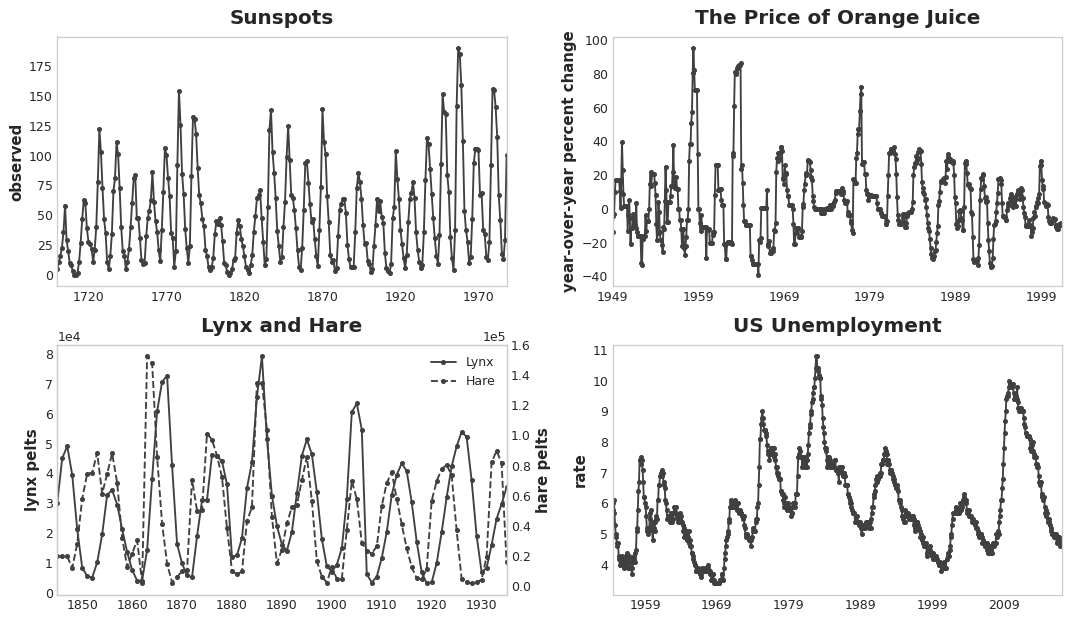

In [42]:
Image('img/cyclic.png')

### Plotting Cycles
#### Via De-Seasonalized Data

In [43]:
store_sales3 = store_sales.copy()
store_sales3.head(2)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0


In [44]:
store_sales3['date'] = store_sales3.date.dt.to_period('D')
store_sales3 = store_sales3.set_index(['store_nbr', 'family', 'date']).sort_index()

# groupby family date mean and select year 2017
family_sales2017 = (
    store_sales3
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']])

family_sales2017.head(2)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222222  0.000000   
2017-01-02  11.481481  0.259259  11.648148  6208.055556  0.481481   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518519    3.629167   
2017-01-02   844.836296   14.203704  2233.648148  1545.000000  539.114833   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   

                                                                      \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS  PRODUCE   
date                                                                   
2017-01-01                     0.0  0.000000       0.037037  0.12963   
2017-01-02                     0.0  0.259259       1.166667  5.62963   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  

[2 rows x 66 columns]

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series.

In [45]:
store_sales['family'].value_counts().head()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
Name: family, dtype: int64

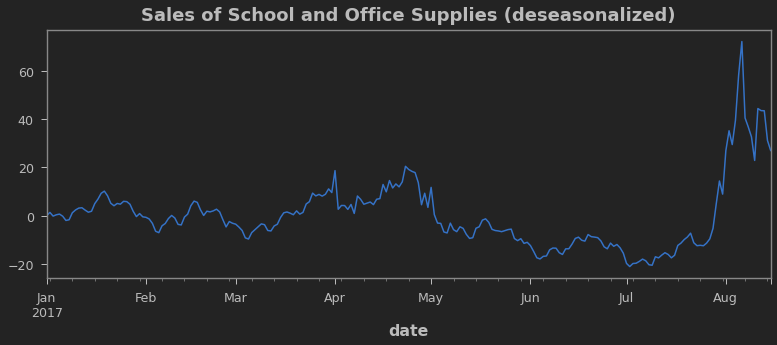

In [46]:
# extract only 'SCHOOL AND OFFICE SUPPLIES' sales data
# from multiindex columns and set it as target
office_sales = family_sales2017.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y_cyc = office_sales.sales.squeeze()

# seasonality order was determined via "average_sales" in 
# Seasonality section to be 4
fourier_cyc = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y_cyc.index,
    constant=True,
    seasonal=True,
    order=1, 
    drop=True,
    additional_terms=[fourier_cyc])

X_cyc_time = dp.in_sample()
X_cyc_time['NewYearsDay'] = (X_cyc_time.index.dayofyear == 1)

model_cyc = LinearRegression(fit_intercept=False).fit(X_cyc_time, y_cyc)
y_cyc_deseason = y_cyc - model_cyc.predict(X_cyc_time)

ax = y_cyc_deseason.plot()
_ = ax.set_title('Sales of School and Office Supplies (deseasonalized)')

Large deviations from 0 indicate cyclic or non-seasonal behaviour. There is easier way however to capture cyclic behaviour:

#### Via Moving Average
To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

This time we do not have to deseasonalixe the target data.

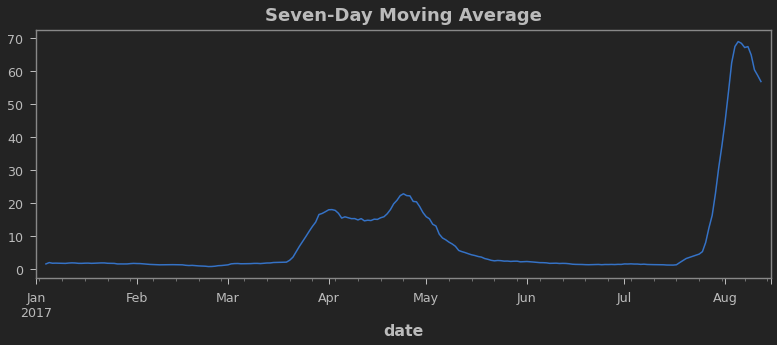

In [47]:
# 7-day moving average
y_ma_cyc = y_cyc.rolling(window=7, center=True).mean()

ax = y_ma_cyc.plot()
_ = ax.set_title("Seven-Day Moving Average")

Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

## Lag Features
To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. 

Lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

Modeling cycles with lag features will allow our forecaster to <code>react dynamically</code> to changing conditions instead of being constrained to exact dates and times as with seasonal features.

In [48]:
# Lag features let us fit curves to lag plots where each observation in a 
# series is plotted against the previous observation.# define function to create lags
def make_lags(ts, lags, lead_time=1):
    """generate lags to a time series ts."""
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis='columns')

# define function to create leads
def make_leads(ts, leads, name='lead'):
    """generate lags to a time series ts."""
    return pd.concat(
        {
            f'y_{name}_{i}': ts.shift(-i)
            for i in range(leads, 0, -1)
        },
        axis='columns')

### Example #1

In [49]:
df2['Lag_1'] = df2['Hardcover'].shift(periods=1)
df2 = df2.reindex(columns=['Hardcover', 'Lag_1'])
df2.head(3)

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0


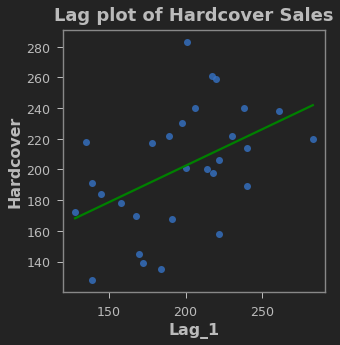

In [50]:
# plot Hardcover vs Lag_1
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.regplot(x='Lag_1', y='Hardcover', data=df2, ci=None, 
                 line_kws={'color': 'green'})
ax.set_aspect('equal')
ax.set_title('Lag plot of Hardcover Sales')

plt.show()

You can see from the lag plot that sales on one day (Hardcover) are correlated with sales from the previous day (Lag_1). When you see a relationship like this, you know a lag feature will be useful. 

More generally, lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

### Example #2

In [51]:
reserve_lag = reserve.copy()
reserve_lag.head(2)

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
Date,,,,,,,
1954-07-01,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1954-08-01,NaN,NaN,NaN,1.22,NaN,6.0,NaN


In [52]:
# extract target column
y_lag = reserve_lag.loc[:, 'Unemployment Rate'].dropna().to_period('M')

df_lag = pd.DataFrame({
    'y': y_lag,
    'y_lag_1': y_lag.shift(1),
    'y_lag_2': y_lag.shift(2)
})
df_lag.head(4)

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0


To forecast the US unemployment rate series, we could use <code>y_lag_1</code> and <code>y_lag_2</code> as features to predict the target <code>y</code>. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

### Lag Plot

Serial dependence in a time series will often become apparent by looking at a lag plot. 
 
The most commonly used measure of serial dependence is known as <code>autocorrelation</code>, which is simply the correlation a time series has with one of its lags. 

In [53]:
# define functions to plot multiple lags
def lagplot(x, y=None, lag=1, lead=None, standardize=False, ax=None, **kwargs):
    """Plot a lagplot."""
    from matplotlib.offsetbox import AnchoredText
    
    if lead is not None:
        x_ = x.shift(-lead)
    else:
        x_ = x.shift(lag)
        
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
        
    scatter_kws = dict(s=3)
    line_kws = dict(color='red')
    
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large", color='grey', 
                  backgroundcolor=ax.get_facecolor()),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    if lead is not None:
        ax.set(title=f"Lead {lead}", xlabel=x_.name, ylabel=y_.name)
    else:
        ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=0, leads=0, nrows=1, lagplot_kwargs={}, **kwargs):
    """Plot multiple lag plots."""
    import math
    
    leadlag_sum = lags + leads
    
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(leadlag_sum / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    
    n_axes = range(kwargs['nrows'] * kwargs['ncols'])
    leadlag_ndx = [*range(leads, 0, -1)] + [*range(1, lags+1)]
    leadlag_name = ['lead'] * leads + ['lag'] * lags
    
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k, name, ndx in zip(fig.get_axes(), n_axes, 
                                leadlag_name, leadlag_ndx):

        if k + 1 <= leadlag_sum:
            if name == 'lag':
                ax = lagplot(x, y, lag=ndx, ax=ax, **lagplot_kwargs)
                ax.set_title(f"Lag {ndx}", fontdict=dict(fontsize=14))
                ax.set(xlabel="", ylabel="")
            else:
                ax = lagplot(x, y, lead=ndx, ax=ax, **lagplot_kwargs)
                ax.set_title(f"Lead {ndx}", fontdict=dict(fontsize=14))
                ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
        
    fig.supxlabel(x.name, weight='bold')
    fig.supylabel(y.name if y is not None else x.name, weight='bold')
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

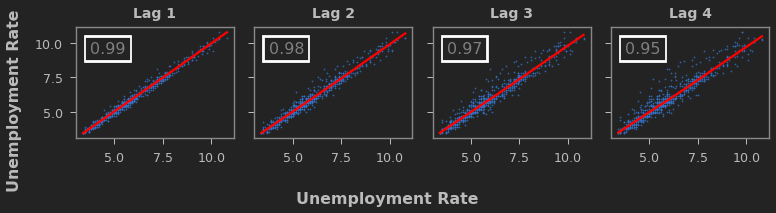

In [54]:
unemployment_lag = reserve_lag['Unemployment Rate'].dropna().to_period('M')

_ = plot_lags(x=unemployment_lag,lags=4, figsize=(11,3))

### Choosing Lags
When choosing lags to use as features, it generally won't be useful to include every lag with a large autocorrelation. In *US Unemployment*, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.

The <code>partial autocorrelation</code> tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. lotting the partial autocorrelation can help you choose which lag features to use.

#### Correlogram

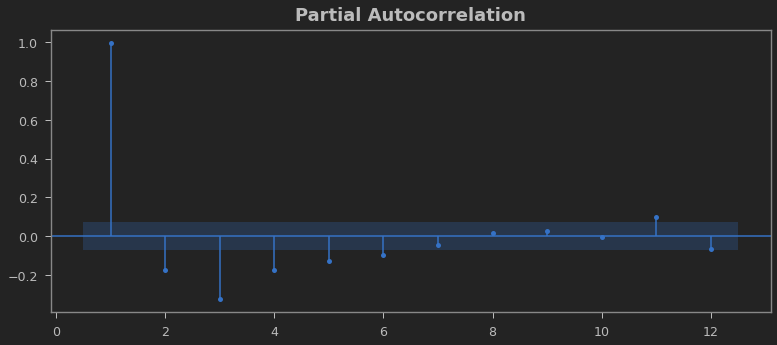

In [55]:
# to plot correlogram we use following import
# from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(x=unemployment_lag, lags=12, zero=False)

Partial autocorrelations of US Unemployment through lag 12 with 95% confidence intervals of no correlation.

In the figure above, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for *US Unemployment*. 
 
A plot like that above is known as a correlogram. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of <code>linear dependence</code>. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like mutual information) when choosing lag features.

### Example #3
The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches. In the first we'll forecast doctor's visits using lag features. Our second approach will be to forecast doctor's visits using lags of another set of time series: flu-related search terms as captured by Google Trends.

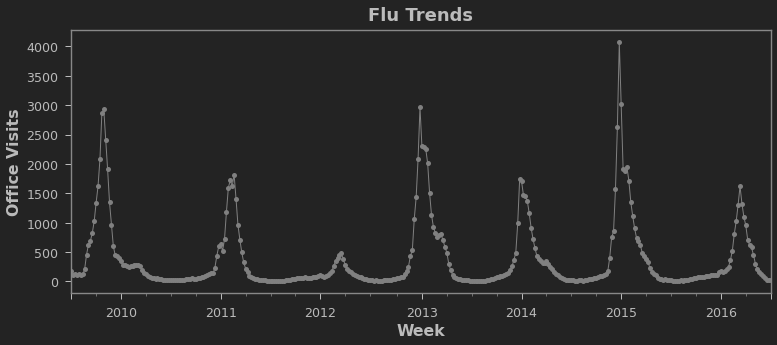

In [56]:
ax = flu_trends['FluVisits'].plot(title='Flu Trends', style='.-', 
            ylabel='Office Visits', color='grey', ms=10, lw=1)

Our Flu Trends data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

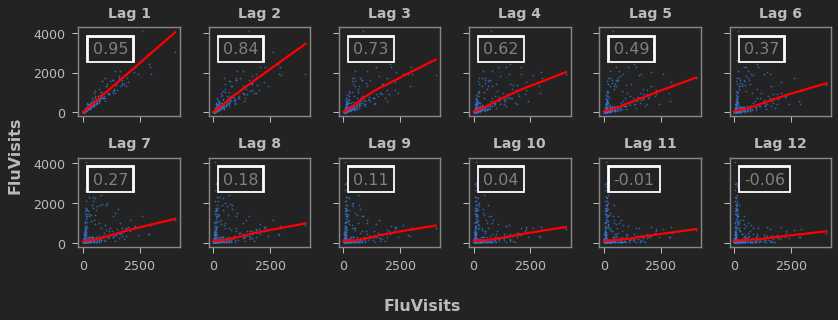

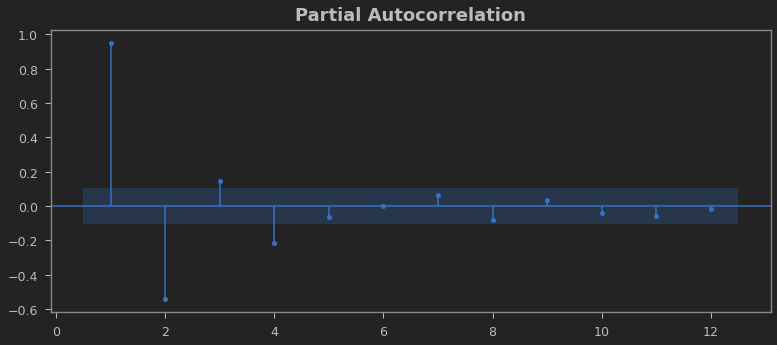

In [57]:
_ = plot_lags(x=flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(x=flu_trends.FluVisits, lags=12, zero=False)

The lag plots indicate that the relationship of FluVisits to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4.

In [58]:
# create lag features 1-4 and fill missing values with 0-s
X_flu_lags = make_lags(flu_trends.FluVisits, lags=4).fillna(0.0)

Previously we were able to create forecasts for as many steps as we liked beyond the training data. <font color='red'>When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.</font>


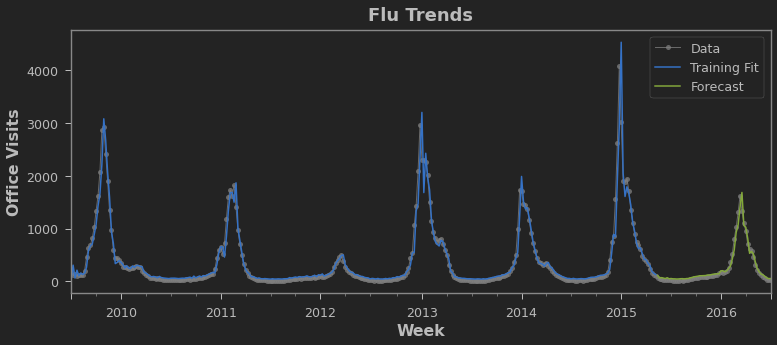

In [59]:
# lets create data splits and the model
y_flu = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X_flu_lags, y_flu, test_size=60, shuffle=False)

# fit a model nad predict
model_flu = LinearRegression().fit(X_train, y_train)
y_pred = pd.Series(model_flu.predict(X_train), index=X_train.index)
y_fore = pd.Series(model_flu.predict(X_test), index=X_test.index)

# plot the result
ax = y_flu.plot(title='Flu Trends', ylabel='Office Visits', style='.-', 
            color='grey', ms=10, lw=1, alpha=0.75, label='Data')
y_pred.plot(ax=ax, label='Training Fit')
y_fore.plot(ax=ax, label='Forecast')

_ = ax.legend()

Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

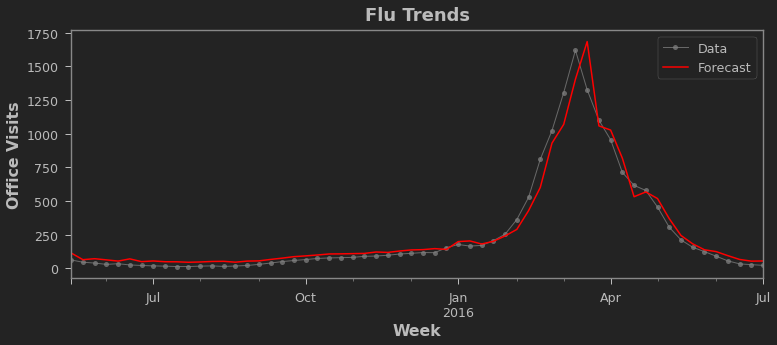

In [60]:
ax = y_test.plot(title='Flu Trends', ylabel='Office Visits', label='Data',
                style='.-', color='grey', ms=10, lw=1, alpha=0.75)
y_fore.plot(ax=ax, label='Forecast', color='red')
_ = ax.legend()

To improve the forecast we could try to find <code>leading indicators</code>.

## Leading Indicators
Time series that could provide an "<code>early warning</code>" for changes in flu cases. 

### Example #1
For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase <code>'FluCough'</code> against the target <code>'FluVisits'</code> suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

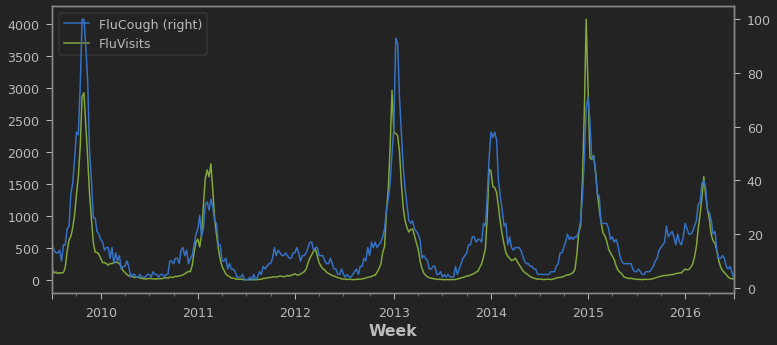

In [61]:
ax = flu_trends.plot(y=["FluCough", "FluVisits"], secondary_y="FluCough")

The dataset contains 129 such terms, but we'll just use a few.

In [62]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", 
                "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0_lags = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1_lags = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X_flu_leading = pd.concat([X0_lags, X1_lags], axis='columns').fillna(0.0)

# column names are clunky, lets rename columns
new_cols = [f"{x[0]}_{x[1]}" if type(x) is tuple else x 
            for x in X_flu_leading.columns]

X_flu_leading.columns = new_cols
X_flu_leading.head(0)

,y_lag_1_FluContagious,y_lag_1_FluCough,y_lag_1_FluFever,y_lag_1_InfluenzaA,y_lag_1_TreatFlu,y_lag_1_IHaveTheFlu,y_lag_1_OverTheCounterFlu,y_lag_1_HowLongFlu,y_lag_2_FluContagious,y_lag_2_FluCough,...,y_lag_3_FluFever,y_lag_3_InfluenzaA,y_lag_3_TreatFlu,y_lag_3_IHaveTheFlu,y_lag_3_OverTheCounterFlu,y_lag_3_HowLongFlu,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,,,,,,,,,,,,,,,,,,


Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

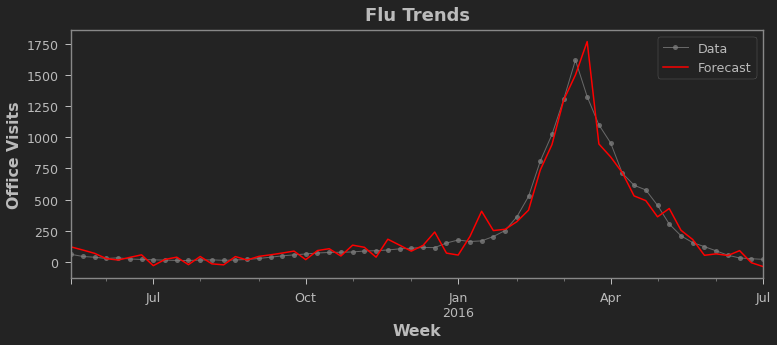

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_flu_leading, y_flu,
        test_size=60, shuffle=False)

model_lead = LinearRegression().fit(X_train, y_train)
y_lead_pred = pd.Series(model_lead.predict(X_train), index=X_train.index)
y_lead_fore = pd.Series(model_lead.predict(X_test), index=X_test.index)

ax = y_test.plot(title='Flu Trends', ylabel='Office Visits', label='Data',
                style='.-', color='grey', ms=10, lw=1, alpha=0.75)
y_lead_fore.plot(ax=ax, label='Forecast', color='red')
_ = ax.legend()


The time series illustrated in this lesson are what you might call "purely cyclic": they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. You can even combine models trained to learn the components separately, which we'll learn how to do in the next lesson with forecasting hybrids.

### Example #2

Lets check how our store sales deseasonalized model fits with the our SCHOOL AND OFFICE SUPPLY sales data after deseasonalizing it.

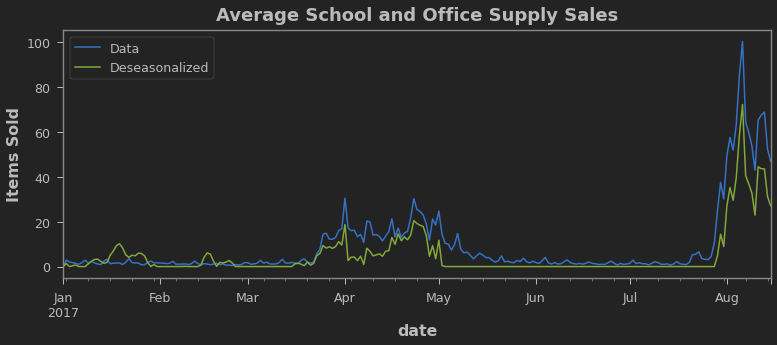

In [64]:
y_cyc_pred = pd.Series(model_cyc.predict(X_cyc_time), index=X_cyc_time.index)

ax = y_cyc.plot(title="Average School and Office Supply Sales", label='Data', 
                ylabel='Items Sold')
ax = y_cyc_deseason.clip(0.0).plot(ax=ax, label='Deseasonalized')
_ = ax.legend()

Now that we have removed seasonality from the charts, we can focus on serialisation. Lets investigate possible lags.

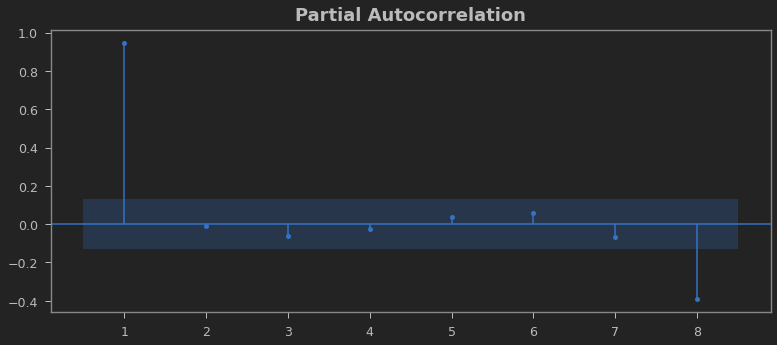

In [65]:
_ = plot_pacf(y_cyc_deseason, lags=8, zero=False)

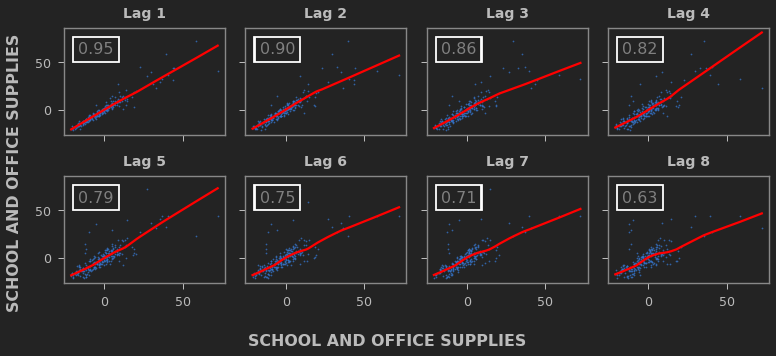

In [66]:
_ = plot_lags(y_cyc_deseason, lags=8, nrows=2, figsize=(11, 5))

The correlogram indicates the <code>first</code> lag is likely to be significant, as well as possibly the <code>eighth</code> lag. The lag plot suggests the effect is mostly <code>linear</code>.

Recall from the tutorial that a <code>leading indicator</code> is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the <code>onpromotion</code> series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's <code>onpromotion</code> value to forecast sales on Monday, for instance.

In [67]:
# lets examine leading and lagging values for on promotion sales
office_sales.head(2)

,sales,onpromotion
family,SCHOOL AND OFFICE SUPPLIES,SCHOOL AND OFFICE SUPPLIES
date,,
2017-01-01,0.000000,0.0
2017-01-02,2.925926,0.0


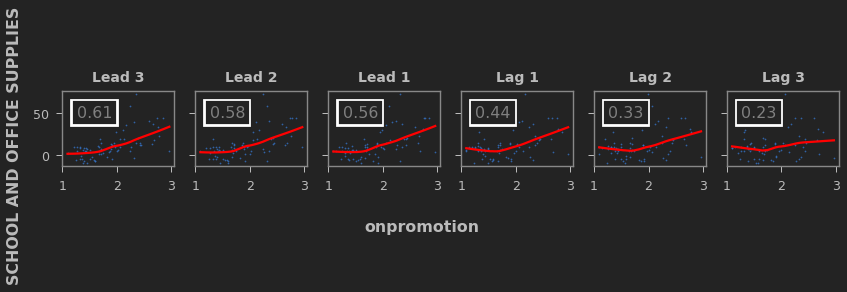

In [68]:
# capture onpromotion into Series object
onpromo = office_sales['onpromotion'].squeeze().rename('onpromotion')

# drop days without promotion
promo = onpromo[onpromo > 1]

# plot lags
_ = plot_lags(x=promo, y=y_cyc_deseason[onpromo > 1], lags=3, leads=3, nrows=1)

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

In [69]:
# create leads and lags to our data from our target
y_cyc_deseason.to_frame().head(2)

,SCHOOL AND OFFICE SUPPLIES
date,
2017-01-01,2.176037e-14
2017-01-02,1.362820e+00


In [70]:
# create lags on SUPPLIES sales
X_supply_lags = make_lags(y_cyc_deseason, lags=1)
# create lags and leads on SPPLIES onpromotion
X_promo = pd.concat([make_lags(onpromo, lags=1), 
                    onpromo,
                    make_leads(onpromo, leads=1)], axis='columns')

# join newly created features to our deseasoned data
X_leading_ind = pd.concat([X_cyc_time, X_supply_lags, X_promo], 
                          axis='columns').dropna()

# align target and features
y_raw, X_leading_ind = y_cyc.align(X_leading_ind, join='inner')

In [71]:
X_leading_ind.head(2)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay,y_lag_1,y_lag_1,onpromotion,y_lead_1
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.918958,0.571268,0.820763,0.724793,0.688967,False,2.176037e-14,0.0,0.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.688967,0.937752,0.347305,0.998717,-0.050649,False,1.362820e+00,0.0,0.0,0.0


Lets see how our model with additional features predicts the sales.

Training RMSLE: 0.23974
Validation RMSLE: 0.34991


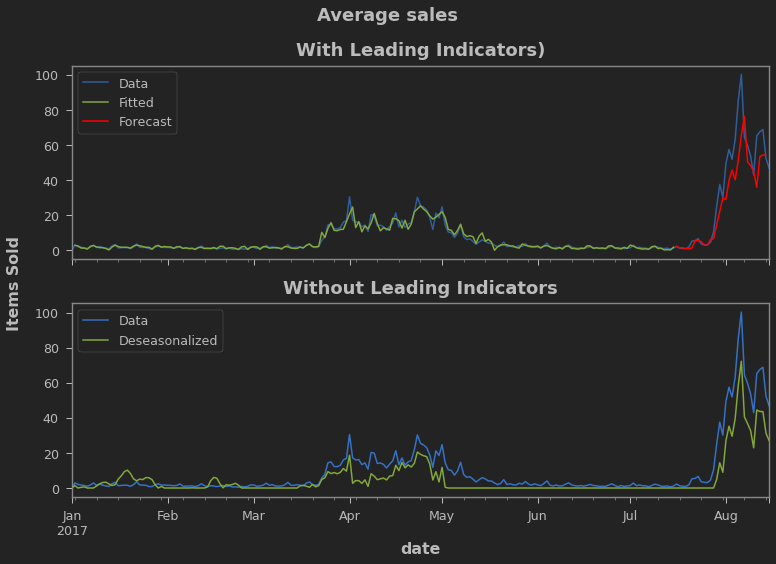

In [72]:
# let's use some of training data for predictions
X_train, X_valid, y_train, y_valid = train_test_split(X_leading_ind, 
    y_raw.clip(0.0), test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_true=y_train, y_pred=y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

# compare forecasting with and without leading indicators
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11,8))
plt.suptitle('Average sales', fontsize=18, weight='bold')
fig.supylabel('Items Sold', weight='bold')

y_cyc.plot(alpha=0.75, title='With Leading Indicators)', label='Data', 
           ax=axes[0])
y_fit.plot(label='Fitted', ax=axes[0])
y_pred.plot(label='Forecast', color='red', ax=axes[0])

y_cyc.plot(title="Without Leading Indicators", label='Data', ax=axes[1])
y_cyc_deseason.clip(0.0).plot(ax=axes[1], label='Deseasonalized')

_ = axes[0].legend()
_ = axes[1].legend()

## Statistical Features

### Lookahead Leakage
Winners of Kaggle forecasting competitions have often included moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use center=False (the default) in the rolling method. Second, the target should be lagged a step.

In [73]:
office_sales.head(2)

,sales,onpromotion
family,SCHOOL AND OFFICE SUPPLIES,SCHOOL AND OFFICE SUPPLIES
date,,
2017-01-01,0.000000,0.0
2017-01-02,2.925926,0.0


In [74]:
# extract features
# target to be lag feature in order to be ahead
y_stat_lag = office_sales.loc[:, 'sales'].shift(1)
onpromo_stat = office_sales.loc[:, 'onpromotion']

y_stat_lag.index.dtype

period[D]

In [75]:
# 28-day mean of lagged target
mean_28 = y_stat_lag.rolling(28).mean()
# 14-day median of lagged target
median_14 = y_stat_lag.rolling(14).median()
# 7-day rolling standard deviation of lagged target
std_7 = y_stat_lag.rolling(7).std()
# 7-day sum of promotions with centered window
promo_7 = onpromo_stat.rolling(7, center=True).sum()

In [76]:
X_stat = pd.concat([X_leading_ind, mean_28, median_14, 
                    std_7, promo_7], axis='columns').dropna()

y_raw, X_stat = y_cyc.align(X_stat, join='inner')

In [77]:
X_stat.shape

(196, 25)

Training RMSLE: 0.27236
Validation RMSLE: 0.37090


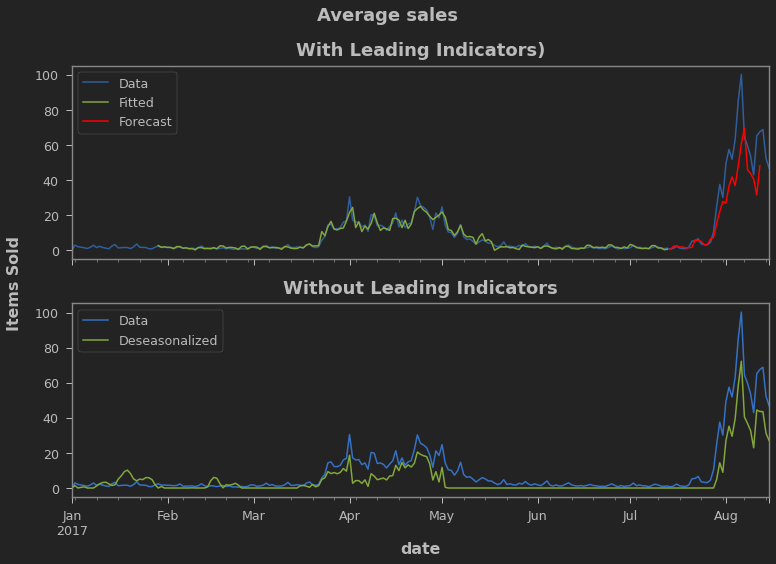

In [78]:
# let's use some of training data for predictions
X_train, X_valid, y_train, y_valid = train_test_split(X_stat, 
    y_raw.clip(0.0), test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_true=y_train, y_pred=y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

# compare forecasting with and without leading indicators
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11,8))
plt.suptitle('Average sales', fontsize=18, weight='bold')
fig.supylabel('Items Sold', weight='bold')

y_cyc.plot(alpha=0.75, title='With Leading Indicators)', label='Data', 
           ax=axes[0])
y_fit.plot(label='Fitted', ax=axes[0])
y_pred.plot(label='Forecast', color='red', ax=axes[0])

y_cyc.plot(title="Without Leading Indicators", label='Data', ax=axes[1])
y_cyc_deseason.clip(0.0).plot(ax=axes[1], label='Deseasonalized')

_ = axes[0].legend()
_ = axes[1].legend()

# Hybrid Models
Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. In this lesson, we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

## Components and Residuals
So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've studied up to now three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random <code>error</code>:

<code>series = trend + seasons + cycles + error</code>

Each of the terms in this model we would then call a <code>component</code> of the time series. 
The <code>residuals</code> of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.

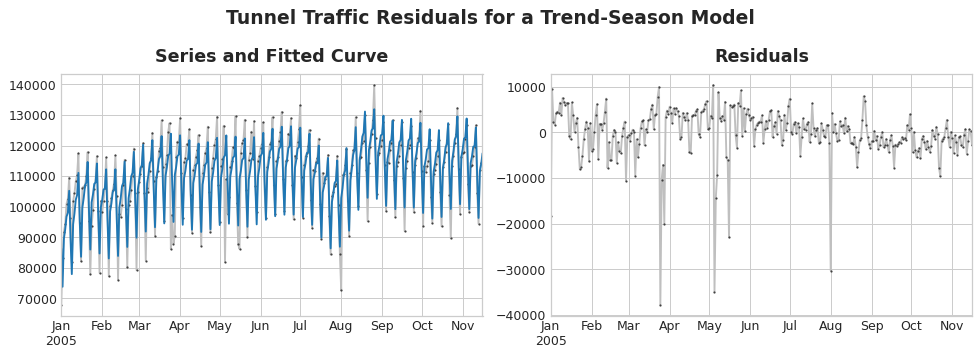

In [79]:
Image('img/residuals.png')

On the left of the figure above is a portion of the *Tunnel Traffic* series and the trend-seasonal curve. Subtracting out the fitted curve leaves the residuals, on the right. The residuals contain everything from *Tunnel Traffic* the trend-seasonal model didn't learn.

We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended residuals and subtract the seasons out, then learn the cycles and subtract the cycles out, and finally only the unpredictable error remains.

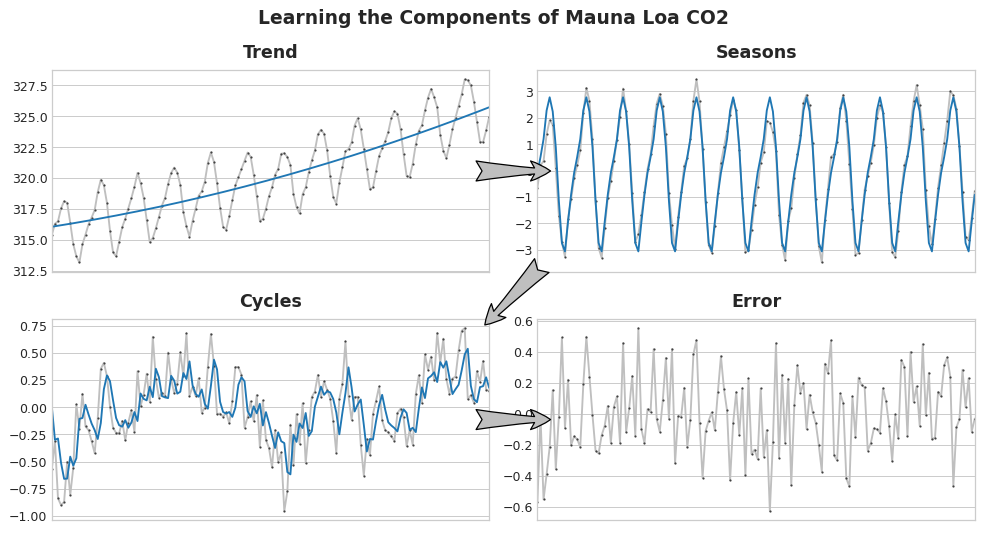

In [80]:
Image('img/iter_components.png')

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.


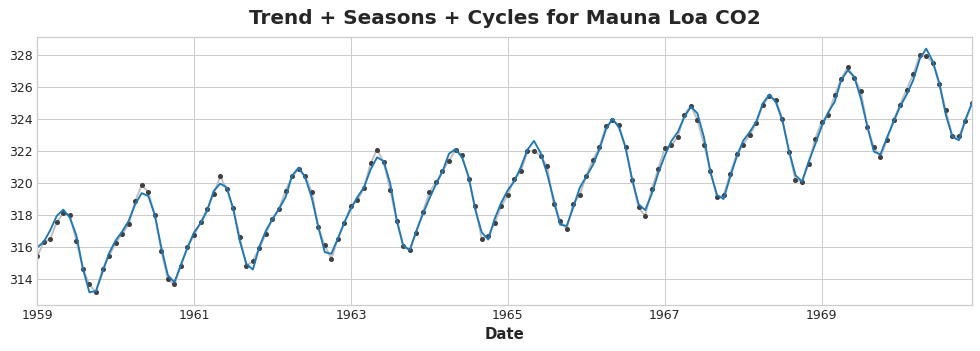

In [81]:
Image('img/complete_model.png')

## Hybrid Forecasting with Residuals
We used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

Process in detail:


<pre><code>model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)</code>

<code>model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)</code>

<code>y_pred = y_pred_1 + y_pred_2</code></pre>

We'll usually want to use different feature sets (X_train_1 and X_train_2 above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

## Designing Hybrids
There are generally two ways a regression algorithm can make predictions: either by transforming the <code>features</code> or by transforming the <code>target</code>. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can <code>extrapolate</code> target values beyond the training set given appropriate features as inputs, but the predictions of <font color='red'>target transformers will always be bound within the range of the training set</font>. 

If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

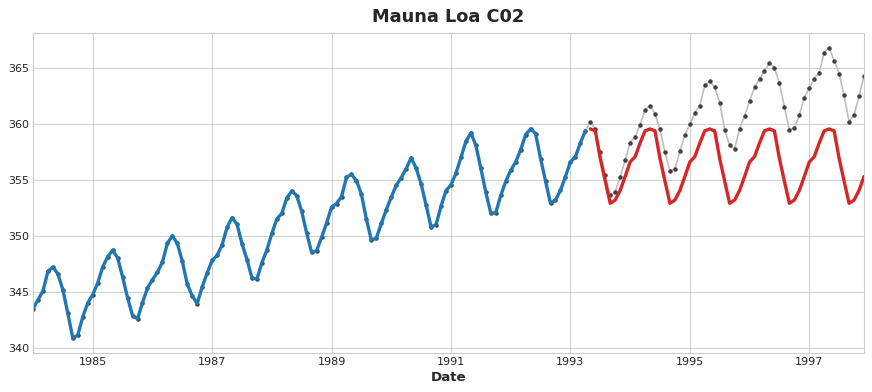

In [82]:
Image('img/dec_tree_trend.png')

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. 

The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted hybrids**; the method of using predictions as features is known as "stacking", so we will call these **stacked** hybrids.

### Example #1
The *US Retail Sales* dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [83]:
retail_sales.head(2)

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01-01,6938,3657,29589,26788,14996,8964
1992-02-01,7524,3490,28570,28203,16015,9023


In [84]:
retail_hyb = retail_sales.copy()
industries = ['BuildingMaterials', 'FoodAndBeverage']

retail_hyb = retail_hyb[industries].to_period('D').reindex(columns=industries)
retail_hyb = pd.concat({'Sales': retail_hyb}, names=[None, 'Industries'], 
                       axis='columns')

retail_hyb.head(2)

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570

First let's use a linear regression model to learn the trend in each series. For demonstration, we'll use a quadratic (order 2) trend. 

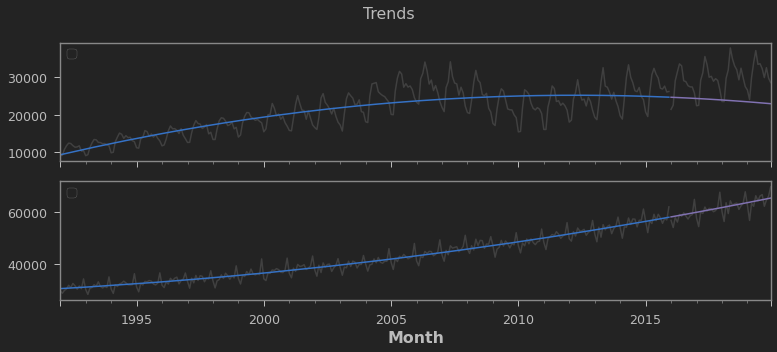

In [85]:
y = retail_hyb.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True)      # drop terms to avoid collinearity
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(y.index, 
                      test_size=12 * 4, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index,columns=y_train.columns)

y_pred = pd.DataFrame(model.predict(X_test),
                      index=y_test.index,
                      columns=y_test.columns)

# Plot
axs = y_train.plot(color='0.25', subplots=True)
axs = y_test.plot(color='0.25', subplots=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from wide format, with one time series per column, to long format, with series indexed by categories along rows.

In [86]:
# The `stack` method converts column labels to row labels, 
# pivoting from wide format to long
X = retail_hyb.stack()  # pivot dataset wide to long
y = X.pop('Sales')      # grab target series

X.head()

Empty DataFrame
Columns: []
Index: [(1992-01-01, BuildingMaterials), (1992-01-01, FoodAndBeverage), (1992-02-01, BuildingMaterials), (1992-02-01, FoodAndBeverage), (1992-03-01, BuildingMaterials)]

In [87]:
y.head()

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
Name: Sales, dtype: int64

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for 'Industries' into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [88]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')

# Label encoding for 'Industries' feature. Grab 0-th element since
# factorize() returns a tuple with list of encodings and index
X.loc[:, 'Industries'] = X.Industries.factorize()[0]

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [89]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor().fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

The fit appears quite good, though we can see how the trend learned by XGBoost is only as good as the trend learned by the linear regression -- in particular, XGBoost wasn't able to compensate for the poorly fit trend in the 'BuildingMaterials' series.

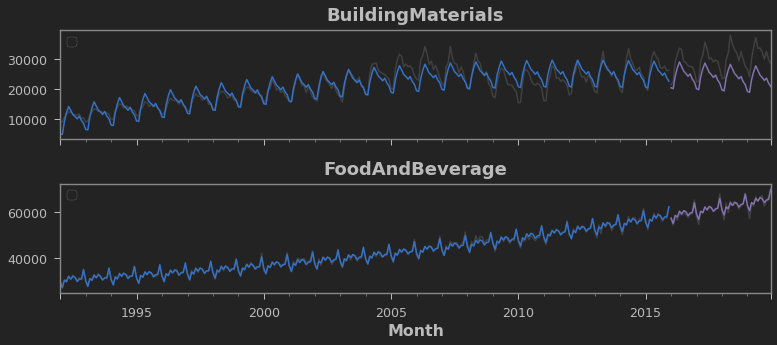

In [90]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, ax=axs,
)
for ax in axs: ax.legend([])

### Example #2

In [91]:
store_sales = pd.read_csv('data/store_sales_train.csv',
            usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
            parse_dates=['date'],
            infer_datetime_format=True,
            dtype={
                'store_nbr': 'category',
                'family': 'category',
                'sales': 'float64'})

In [92]:
store_sales_hyb = store_sales.copy()
store_sales_hyb.head(1)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [93]:
store_sales_hyb['date'] = store_sales_hyb.date.dt.to_period('D')
store_sales_hyb = store_sales_hyb.set_index(['store_nbr', 'family', 'date'])\
    .sort_index()
store_sales_hyb.head(3)

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0

In [94]:
family_hyb = (
    store_sales_hyb
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .loc['2017'])
family_hyb.head(1)

sales                                                    \
family     AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS BREAD/BAKERY   
date                                                                      
2017-01-01   0.092593  0.037037  0.055556  74.222222   0.0     9.084685   

                                                      ... onpromotion  \
family     CELEBRATION CLEANING      DAIRY      DELI  ...   MAGAZINES   
date                                                  ...               
2017-01-01     0.12963      7.5  11.518519  3.629167  ...         0.0   

                                                                         \
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2017-01-01  0.018519      0.111111     0.018519                     0.0   

                                                                               
family     POULTRY PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                           
2017-01-01     0.0       0.037037  0.12963                        0.0     0.0  

[1 rows x 66 columns]

In [95]:
# create BoostedHybrid Class for more convenient fit and predict
class BoostedHybrid(BaseEstimator, TransformerMixin):
    def __init__(self, model_1, model_2):
        self.model_1  = model_1
        self.model_2 = model_2
        self.y_columns = None # dummy for column names from fit method later
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y) # fit the model
        
        # first model prediction that captures trend
        y_fit = pd.DataFrame(self.model_1.predict(X_1), 
                             index=X_1.index, 
                             columns=y.columns)
        
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long & to series level
        
        # fit 2nd model on features designed for it 
        self.model_2.fit(X_2, y_resid)
        
        # save column names for the predict method
        self.y_columns = y.columns
        # save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
        
        return self
    
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(self.model_1.predict(X_1),
                              index=X_1.index, 
                              columns=self.y_columns)
        
        y_pred = y_pred.stack().squeeze() # wide to long
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack() # long to wide

Setup the data for XGBRegressor

In [96]:
print(f"Top level columns:", family_hyb.columns.levels[0])
family_hyb.head(1)

Top level columns: Index(['sales', 'onpromotion'], dtype='object')


sales                                                    \
family     AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS BREAD/BAKERY   
date                                                                      
2017-01-01   0.092593  0.037037  0.055556  74.222222   0.0     9.084685   

                                                      ... onpromotion  \
family     CELEBRATION CLEANING      DAIRY      DELI  ...   MAGAZINES   
date                                                  ...               
2017-01-01     0.12963      7.5  11.518519  3.629167  ...         0.0   

                                                                         \
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2017-01-01  0.018519      0.111111     0.018519                     0.0   

                                                                               
family     POULTRY PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                           
2017-01-01     0.0       0.037037  0.12963                        0.0     0.0  

[1 rows x 66 columns]

In [97]:
# target
y = family_hyb.loc[:, 'sales']

# features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# features for XGBoost. Drop target 'sales', leave 'onpromotion'
X_2 = family_hyb.stack('family').drop('sales', axis='columns')
X_2.head(3)

onpromotion
date       family                 
2017-01-01 AUTOMOTIVE          0.0
           BABY CARE           0.0
           BEAUTY              0.0

In [98]:
# need to label-encode family values
X_2 = X_2.reset_index('family')
X_2['family'] = X_2.family.factorize()[0]

# add seasonality term "day"
X_2['day'] = X_2.index.day # day of the month
X_2.head(2)

,family,onpromotion,day
date,,,
2017-01-01,0,0.0,1
2017-01-01,1,0.0,1


In [99]:
# create the hybrid model 
model_hyb = BoostedHybrid(LinearRegression(), XGBRegressor())

model_hyb.fit(X_1, X_2, y)
y_pred = model_hyb.predict(X_1, X_2)

# cap negative values with 0
y_pred = y_pred.clip(0.0)

See the predictions

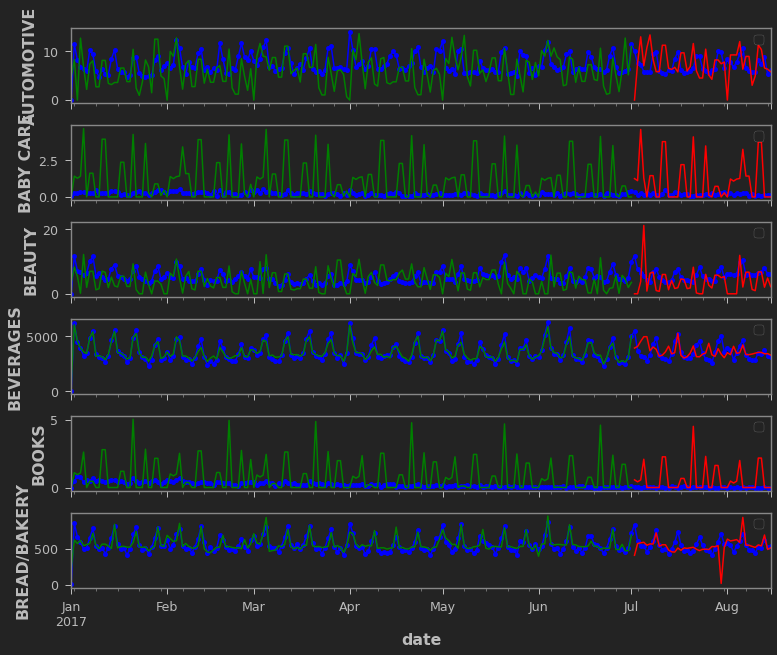

In [100]:
# init model
model_hyb = BoostedHybrid(LinearRegression(), XGBRegressor())

# manually split data
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model_hyb.fit(X1_train, X2_train, y_train)
y_fit = model_hyb.predict(X1_train, X2_train).clip(0.0)
y_pred = model_hyb.predict(X1_valid, X2_valid).clip(0.0)

# grab 6 families
families = y.columns[0:6]
axs = y.loc(axis='columns')[families]\
    .plot(subplots=True, figsize=(11, 9), color='blue', style='.-', ms=10)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, color='green', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, color='red', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# Forecasting
Info neede:
1. What information is available at the time of a forecast is made <code>features</code>.
2. the time period during which you require forecasted values (<code>target</code>).

* <code>forecast origin</code> : time at which forecast is made. Can be the point of last training data. Everything up to he origin can be used to create features.
* <code>forecast horizon</code> : time for which forecast is made. Often described by "number of time steps in its horizon: "1-step" or "5-step" forecast. The forecast horizon describes the <code>target</code>.
* <code>lead time</code> : or **latency**. Essentially number of steps from the <code>origin</code> to <code>horizon</code>. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

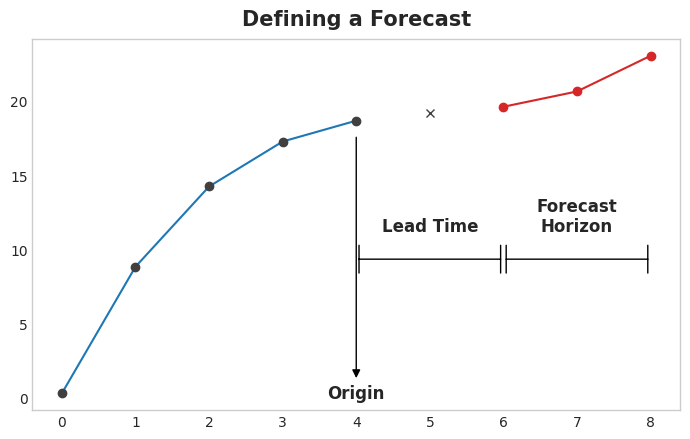

In [101]:
Image('img/forecast.png')

A three-step forecast horizon with a two-step lead time, using four lag features. The figure represents what would be a single row of training data -- data for a single prediction, in other words.

## Preping Data

In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms.m

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.



In [102]:
# create a sample DF by initializing series of 
ts = pd.Series(np.arange(20), index=pd.period_range(2010, freq='A', periods=20, 
                                               name='year'))

# make leading step targets
lead_steps = make_leads(ts, leads=2, name='step')
# make lagging features
lags = make_lags(ts, 6)
df = pd.concat([lead_steps, 
                ts.to_frame(name='y'),
                lags], axis='columns')

# assign multiindex to df to capture targets and features
df = pd.concat({'targets': df.iloc[:,:3],
                'features': df.iloc[:,4:]}, axis='columns')
df.head()

targets             features                                
     y_step_2 y_step_1  y  y_lag_2 y_lag_3 y_lag_4 y_lag_5 y_lag_6
year                                                              
2010      2.0      1.0  0      NaN     NaN     NaN     NaN     NaN
2011      3.0      2.0  1      NaN     NaN     NaN     NaN     NaN
2012      4.0      3.0  2      0.0     NaN     NaN     NaN     NaN
2013      5.0      4.0  3      1.0     0.0     NaN     NaN     NaN
2014      6.0      5.0  4      2.0     1.0     0.0     NaN     NaN

The above illustrates how a dataset would be prepared similar to the *Defining a Forecast* figure: a <code>three-step forecasting</code> task with a <code>two-step lead</code> time using five lag features. The original time series is <code>y</code>. The missing values we could either fill-in or drop.

## Multistep Strategies

### Mutlioutput
Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

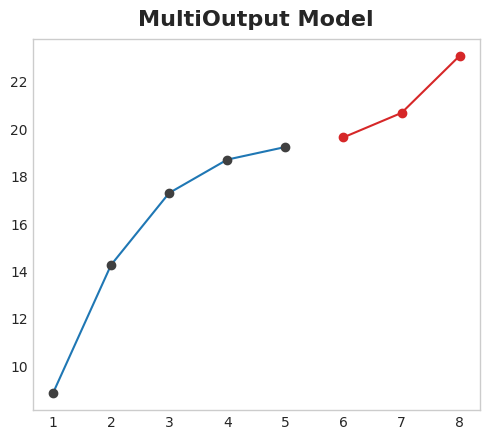

In [103]:
Image('img/multioutput.png', width=300, height=300)

##### Example - Flu Trends
We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

In [104]:
flue_mstep = flu_trends
flue_mstep.head(1)

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180


Prepare our target series (weekly office visits for the flu) for multistep forecasting.

In [105]:
# original target
y = flue_mstep.FluVisits.copy()

# 4-weeks of lag features
X = make_lags(y, lags=4).fillna(0.0)
X.head(2)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0


In [106]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [107]:
# 8-week forecast target, where original target is step 0
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
print("Indices match:", y.index.equals(X.index))
y, X = y.align(X, join='inner', axis='index')
print("Indices match:", y.index.equals(X.index))

Indices match: False
Indices match: True


In [108]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression().fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_fore= pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

In [109]:
# define multi-step plotting function
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

Train RMSE: 389.12
Test RMSE: 582.33


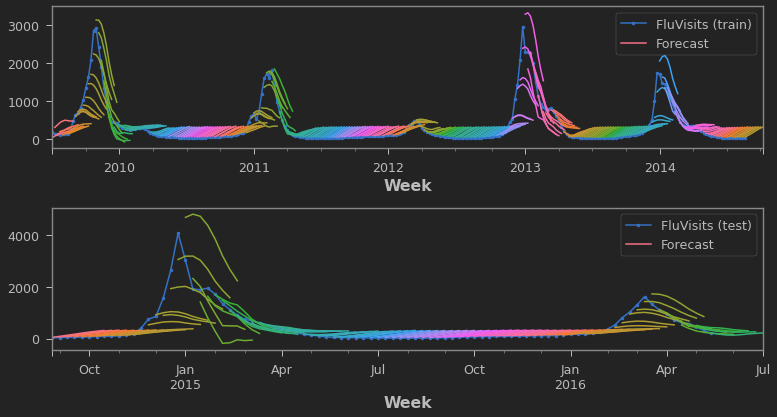

In [110]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_fore, squared=False)

print(f"Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = flue_mstep.FluVisits[y_fit.index].plot(ax=ax1, style='.-', ms=7)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flue_mstep.FluVisits[y_fore.index].plot(ax=ax2, style='.-', ms=7)
ax2 = plot_multistep(y_fore, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct
Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

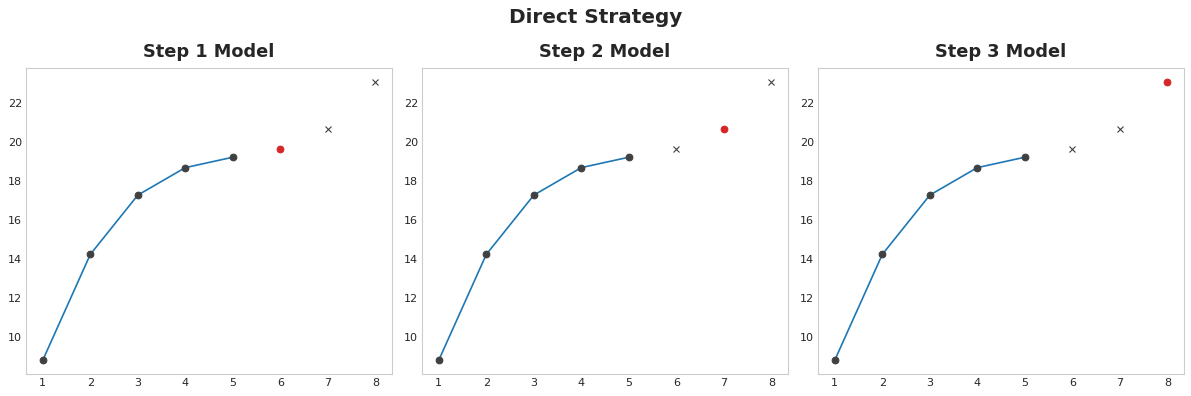

In [111]:
Image('img/direct_strat.png', width=900, height=300)

##### Example Flu Trends 
XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with *scikit-learn's* <code>MultiOutputRegressor</code>

In [112]:
model = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred= pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 1.22
Test RMSE: 526.45


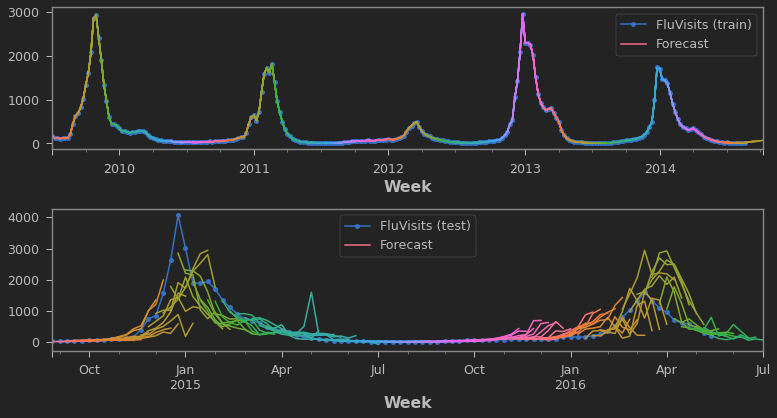

In [115]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = flu_trends.FluVisits[y_fit.index].plot(ax=ax1, style='.-', ms=10)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flu_trends.FluVisits[y_pred.index].plot(ax=ax2, style='.-', ms=10)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

To use the DirRec strategy, you would only need to replace MultiOutputRegressor with another scikit-learn wrapper, RegressorChain. The Recursive strategy we would need to code ourselves.

### Recrusive
Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

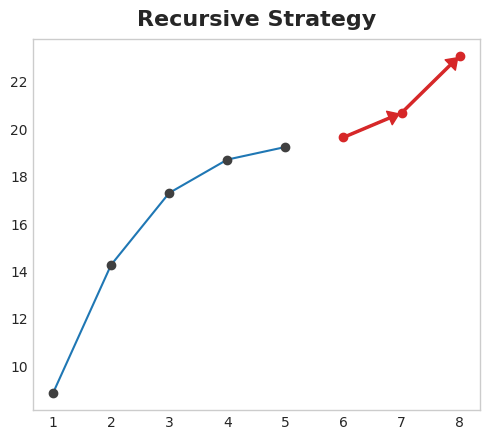

In [116]:
Image('img/recursive_start.png', width=300, height=300)

### DirRec 
A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

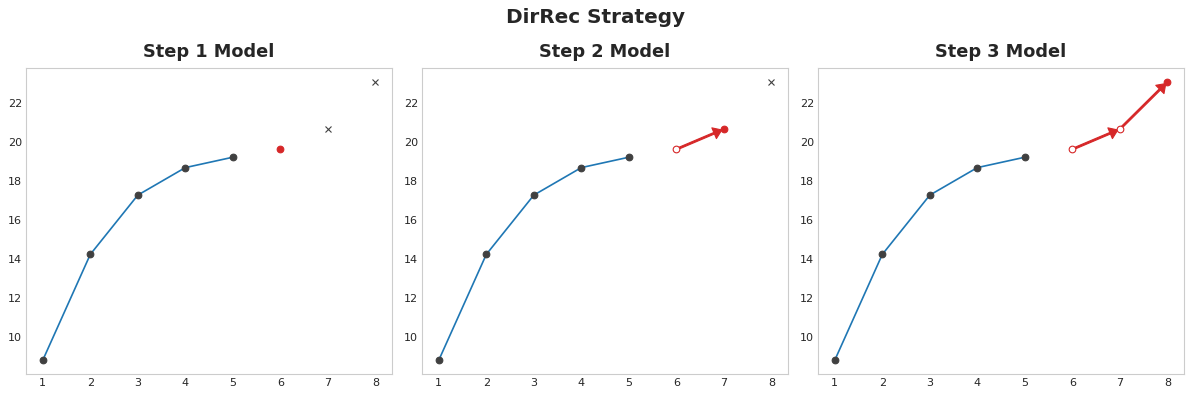

In [117]:
Image('img/dirrec.png', width=900, height=300)

##### Example Flu Trends

In [118]:
# original target
y = flue_mstep.FluVisits.copy()

# 4-weeks of lag features
X = make_lags(y, lags=4).fillna(0.0)

# 8-week forecast target, where original target is step 0
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
print("Indices match:", y.index.equals(X.index))
y, X = y.align(X, join='inner', axis='index')
print("Indices match:", y.index.equals(X.index))

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

Indices match: False
Indices match: True


Train RMSE: 27.88
Test RMSE: 553.20


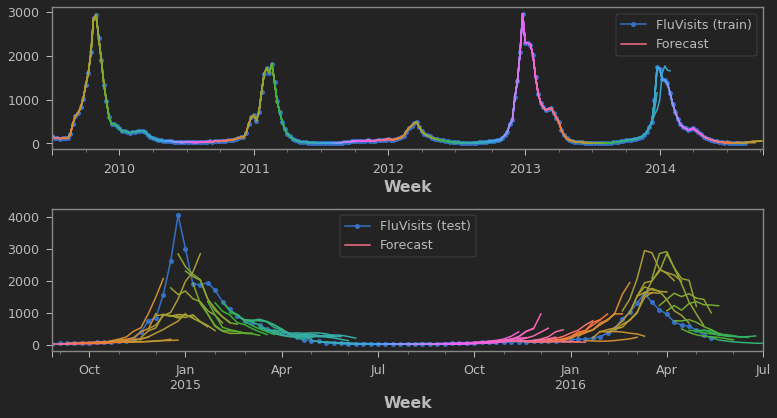

In [119]:
model = RegressorChain(XGBRegressor()).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred= pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = flu_trends.FluVisits[y_fit.index].plot(ax=ax1, style='.-', ms=10)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])

ax2 = flu_trends.FluVisits[y_pred.index].plot(ax=ax2, style='.-', ms=10)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])